### **Notebook 00: Project Environment and System Setup**

This notebook establishes a fully reproducible environment for the analysis pipeline. It is the canonical entry point for all workflows and must be executed in its entirety before any other notebook. The configuration has been validated on an NVIDIA RTX 4060 Laptop GPU (CUDA 12.4) with PyTorch 2.4.1, Python 3.11, and an isolated Conda environment.

All paths are managed relative to the project root, which defaults to `~/Projects/final_project/` unless otherwise specified through the `PROJECT_ROOT` environment variable.

---

### **Phase 1: Manual Asset Placement**

**Objective:** To download and correctly place all large data and model assets that are not included in version control.

**Rationale:** The analysis pipeline depends on external datasets and large pre-trained models. Correct manual placement is a mandatory prerequisite for the automated setup scripts to function correctly.

**Methodology:** The following assets must be downloaded from their official sources and placed into the specified directory structure within the project root. Filenames and directory structures must be preserved exactly.

#### **1.1: CAT2000 Dataset (Eye Tracking Benchmark)**

*   **Purpose:** Provides the stimulus images and human fixation data required for all subsequent analyses.
*   **Acquisition:** The dataset must be downloaded from the official source: [https://saliency.tuebingen.ai/datasets.html](https://saliency.tuebingen.ai/datasets.html)
*   **Action:** Unpack the downloaded archive. Place the contents into the `data/` directory. Ensure the final paths match the required location.
*   **Required Location:** `<PROJECT_ROOT>/data/CAT2000/trainSet/Stimuli/*.jpg`
*   **Verification:** Confirm that all stimulus images are located inside the `Stimuli/` subdirectory and not directly under `trainSet/`.

#### **1.2: Qwen2.5-VL-7B-Instruct GGUF Model Files**

*   **Purpose:** These files contain the quantized vision-language model weights used for image-semantic annotation via `llama.cpp`.
*   **Acquisition:** Obtain the files from the Hugging Face repository: [https://huggingface.co/bartowski/Qwen_Qwen2.5-VL-7B-Instruct-GGUF](https://huggingface.co/bartowski/Qwen_Qwen2.5-VL-7B-Instruct-GGUF)
*   **Required Files:**
    *   `Qwen_Qwen2.5-VL-7B-Instruct-Q4_K_M.gguf` (main model)
    *   `mmproj-Qwen_Qwen2.5-VL-7B-Instruct-f16.gguf` (vision projection weights)
*   **Action:** Place the downloaded files into the `models/qwen/` directory. Do not change the filenames.

#### **1.3: SAM2.1 Hiera Large Checkpoint for LangSAM**

*   **Purpose:** Provides the segmentation backbone model for the Lang-Segment-Anything (LangSAM) pipeline.
*   **Acquisition:** The file is available from the official Segment Anything 2 repository or the LangSAM fork.
    *   [https://github.com/facebookresearch/segment-anything-2](https://github.com/facebookresearch/segment-anything-2)
    *   [https://github.com/luca-medeiros/lang-segment-anything](https://github.com/luca-medeiros/lang-segment-anything)
*   **Required File:** `sam2.1_hiera_large.state_dict.pt`
*   **Action:** Place the downloaded file into the `models/sam/` directory. Ensure it is the `.state_dict.pt` variant, as other formats are incompatible.

---

### **Phase 2: Automated Environment Setup**

**Objective:** To programmatically generate the `requirements.txt` and `setup.sh` files required to create a clean, reproducible Conda environment.

**Rationale:** Version-controlling the setup scripts ensures that the exact environment can be recreated on any machine, which is fundamental to reproducible research.

**Methodology:** The following Python cell will write two files to the project root. The `setup.sh` script should then be executed from a bash terminal to provision the environment.

**Inputs:** None.
**Outputs:**
*   `PROJECT_ROOT/requirements.txt`
*   `PROJECT_ROOT/setup.sh`

In [5]:
# --- Preamble: Setup and Configuration ---
import os
import sys
from pathlib import Path
from textwrap import dedent
import warnings

# Suppress all warnings for clean output
warnings.filterwarnings("ignore")

# --- Generate Environment Artifacts ---
# This cell generates the setup files but does not run them.

PROJECT_ROOT = Path("/home/nico/Projects/final_project/")
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"[error] Project root does not exist: {PROJECT_ROOT}")
print(f"[info] Project root located: {PROJECT_ROOT}")

# Define the content for requirements.txt
# This includes all core libraries and pins PyTorch to a specific CUDA version.
requirements_txt = dedent("""
# Core scientific stack
pandas==2.2.2
numpy==1.26.4
matplotlib==3.8.4
seaborn==0.13.2
scipy==1.13.1
opencv-python==4.9.0.80
scikit-learn==1.4.2
itables==1.6.3
tabulate==0.9.0
pyyaml==6.0.1
jupyter==1.0.0
dataframe_image==0.1.1
statsmodels==0.14.2
shapely==2.1.1

# PyTorch pinned for CUDA 12.4
torch==2.4.1 --index-url https://download.pytorch.org/whl/cu124
torchvision==0.19.1 --index-url https://download.pytorch.org/whl/cu124

""").strip() + "\n"

# Define the content for the setup.sh bash script
# This script automates the entire environment creation process.
setup_sh = dedent(rf"""
#!/usr/bin/env bash
set -euo pipefail

# --- Configuration ---
ROOT="{PROJECT_ROOT}"
LOG_DIR="$ROOT/logs"
mkdir -p "$LOG_DIR"
LOGFILE="$LOG_DIR/environment_setup.log"

echo "[log] Environment setup started" | tee "$LOGFILE"

# --- 0) Conda Prerequisite Check ---
if ! command -v conda >/dev/null 2>&1; then
  echo "[error] Conda not found. Install Miniconda or Anaconda." | tee -a "$LOGFILE"
  exit 1
fi

# --- 1) Create/Activate Conda Environment ---
ENV_NAME="gaze-project"
PY_VER="3.11"
echo "[step] Creating/using conda env: $ENV_NAME (Python $PY_VER)" | tee -a "$LOGFILE"
source "$(conda info --base)/etc/profile.d/conda.sh"
if ! conda info --envs | awk '{{print $1}}' | grep -qx "$ENV_NAME"; then
  conda create -n "$ENV_NAME" "python=$PY_VER" -y 2>&1 | tee -a "$LOGFILE"
fi
conda activate "$ENV_NAME"

# --- 2) Install System Dependencies ---
echo "[step] Installing system packages" | tee -a "$LOGFILE"
sudo apt-get update -y 2>&1 | tee -a "$LOGFILE"
sudo apt-get install -y build-essential cmake git pkg-config 2>&1 | tee -a "$LOGFILE"

# --- 3) Install PyTorch with CUDA ---
echo "[step] Installing PyTorch CUDA 12.4 wheels" | tee -a "$LOGFILE"
pip install --upgrade pip wheel setuptools 2>&1 | tee -a "$LOGFILE"
pip install --index-url https://download.pytorch.org/whl/cu124 \
  torch==2.4.1 torchvision==0.19.1 2>&1 | tee -a "$LOGFILE"

# --- 4) Install Pinned Python Requirements ---
echo "[step] Installing pinned Python requirements" | tee -a "$LOGFILE"
pip install -r "$ROOT/requirements.txt" 2>&1 | tee -a "$LOGFILE"

# --- 5) Build llama.cpp with CUDA ---
echo "[step] Building llama.cpp with CUDA" | tee -a "$LOGFILE"
cd "$ROOT"
if [ -d "llama.cpp" ]; then
  if ! git -C llama.cpp rev-parse HEAD >/dev/null 2>&1; then
    echo "[warn] Corrupted llama.cpp repo. Removing and recloning." | tee -a "$LOGFILE"
    rm -rf llama.cpp
  fi
fi
if [ ! -d "llama.cpp" ]; then
  git clone https://github.com/ggerganov/llama.cpp.git 2>&1 | tee -a "$LOGFILE"
fi
cd llama.cpp
DEFAULT_BRANCH=$(git remote show origin | awk '/HEAD branch/ {{print $NF}}')
git fetch origin "$DEFAULT_BRANCH" --depth 1 2>&1 | tee -a "$LOGFILE"
git checkout "$DEFAULT_BRANCH" 2>&1 | tee -a "$LOGFILE"
git reset --hard "origin/$DEFAULT_BRANCH" 2>&1 | tee -a "$LOGFILE"
mkdir -p build && cd build
cmake .. -DLLAMA_JSON=ON -DGGML_CUDA=ON 2>&1 | tee -a "$LOGFILE"
cmake --build . --config Release -j 2>&1 | tee -a "$LOGFILE"

# --- 6) Final Verification Imports ---
echo "[step] Verifying Python imports" | tee -a "$LOGFILE"
python - <<'PYCHECK' 2>&1 | tee -a "$LOGFILE"
import sys, torch, torchvision, pandas, numpy, cv2, yaml
print("python", sys.version.split()[0])
print("torch", torch.__version__, "cuda", torch.version.cuda, "is_available", torch.cuda.is_available())
print("torchvision", torchvision.__version__)
print("pandas", pandas.__version__)
print("numpy", numpy.__version__)
print("opencv", cv2.__version__)
PYCHECK

# --- 7) Generate Environment Manifest ---
echo "[step] Writing manifest" | tee -a "$LOGFILE"
python - <<'PYMANIFEST' 2>&1 | tee -a "$LOGFILE"
import json, os, platform, subprocess, time
from pathlib import Path
root = Path(r"{PROJECT_ROOT}")
def git_rev(path: Path):
    try:
        return subprocess.check_output(["git", "rev-parse", "HEAD"], cwd=root).decode().strip()
    except Exception:
        return None
manifest = {{
  "project_root": str(root),
  "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
  "git_commit": git_rev(root),
  "platform": platform.platform(),
}}
out = root / "outputs" / "artifacts"
out.mkdir(parents=True, exist_ok=True)
(out / "manifest.json").write_text(json.dumps(manifest, indent=2))
print(json.dumps(manifest, indent=2))
PYMANIFEST

echo "[done] Environment setup complete." | tee -a "$LOGFILE"
""").strip() + "\n"

# --- Write Artifacts to Disk ---
(PROJECT_ROOT / "requirements.txt").write_text(requirements_txt)
(PROJECT_ROOT / "setup.sh").write_text(setup_sh)

print(f"[ok] Artifacts 'requirements.txt' and 'setup.sh' have been written to {PROJECT_ROOT}")

[info] Project root located: /home/nico/Projects/final_project
[ok] Artifacts 'requirements.txt' and 'setup.sh' have been written to /home/nico/Projects/final_project


#### **Execution Directive**

1.  Open a bash terminal.
2.  Navigate to the project root directory.
3.  Execute the setup script:
    ```bash
    bash setup.sh
    ```

---

### **Phase 3: Verify Model Functionality**

**Objective:** To perform minimal, end-to-end inference tests on the key models (`Qwen-VL` and `LangSAM`) to confirm the environment is fully operational.

**Rationale:** A successful inference pass is the ultimate validation that all dependencies, model weights, and hardware drivers (CUDA) are correctly configured and communicating.

#### **3.1: Qwen-VL Inference Test**

**Methodology:** This test verifies the `llama.cpp` command-line interface. It loads the quantized Qwen-VL model and its vision projector, processes a test image, and generates a textual description. A successful run confirms the build, model paths, and GPU offloading are correct.


[step] Verifying Qwen-VL assets...
[info] Test image: /home/nico/Projects/final_project/test_assets/sample.jpg


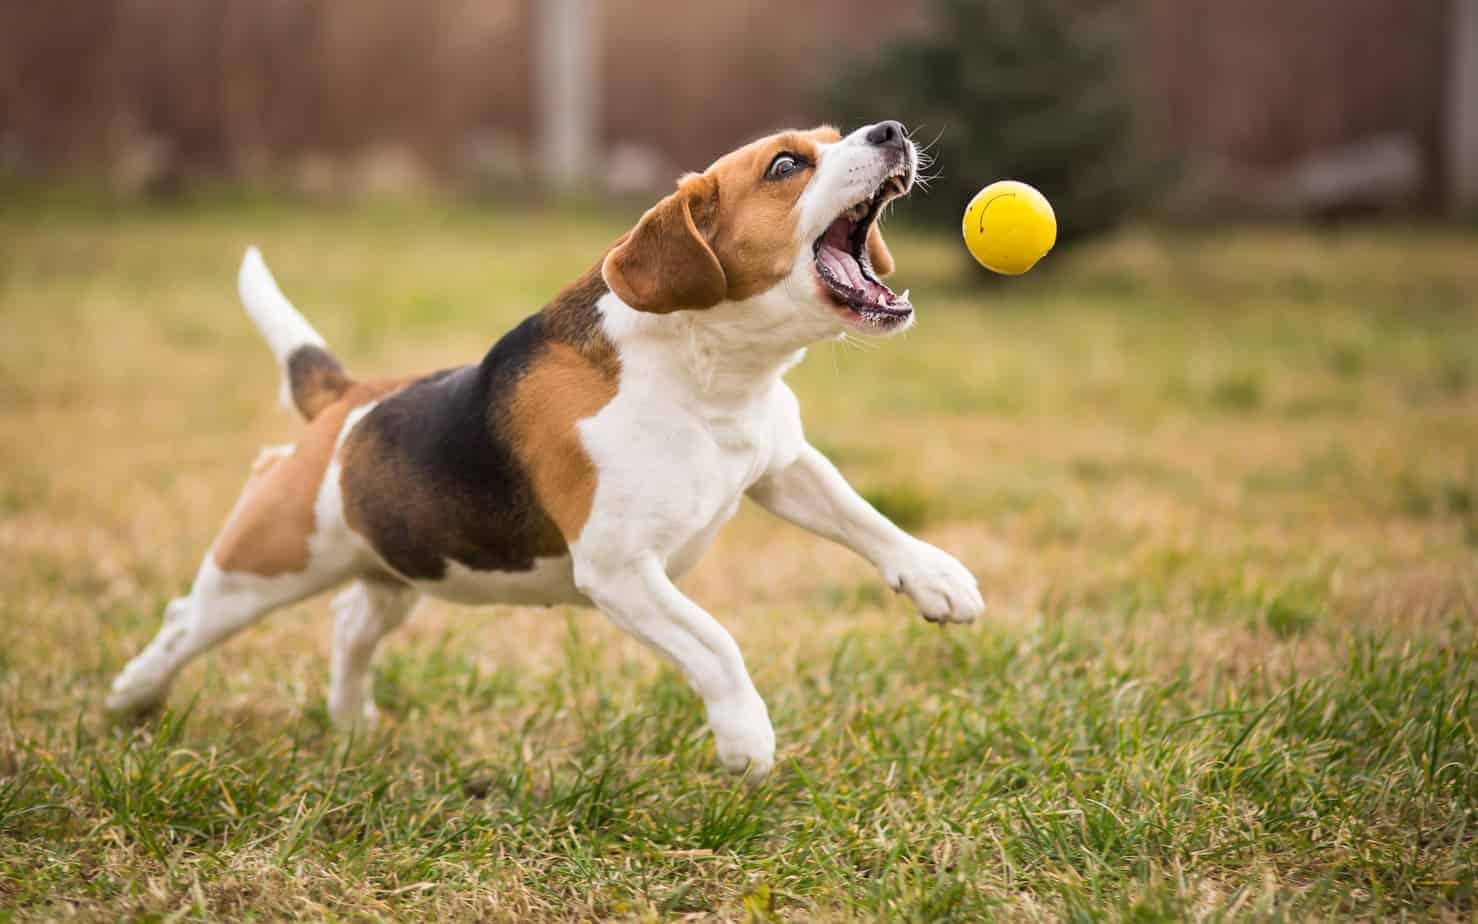

[step] Executing llama-mtmd-cli command...
[ok] Command executed successfully.
[output] Model description: 'A beagle dog chases a yellow tennis ball in a grassy yard.'


In [7]:
# --- Preamble ---
import subprocess
from pathlib import Path
from IPython.display import display, Image

# --- Configuration & Setup ---
PROJECT_ROOT = Path("/home/nico/Projects/final_project/")
LLAMA_MTMD_CLI = PROJECT_ROOT / "llama.cpp" / "build" / "bin" / "llama-mtmd-cli"
MODEL_PATH = PROJECT_ROOT / "models" / "qwen" / "Qwen_Qwen2.5-VL-7B-Instruct-Q4_K_M.gguf"
MMPROJ_PATH = PROJECT_ROOT / "models" / "qwen" / "mmproj-Qwen_Qwen2.5-VL-7B-Instruct-f16.gguf"
SAMPLE_IMAGE_PATH = PROJECT_ROOT / "test_assets" / "sample.jpg"

# --- Verify Asset Paths ---
print("[step] Verifying Qwen-VL assets...")
for path, desc in [
    (LLAMA_MTMD_CLI, "llama-mtmd-cli"), (MODEL_PATH, "Qwen model"),
    (MMPROJ_PATH, "Qwen projector"), (SAMPLE_IMAGE_PATH, "Sample image")
]:
    assert path.exists(), f"[error] {desc} not found at: {path}"

# --- Display Test Image ---
print(f"[info] Test image: {SAMPLE_IMAGE_PATH}")
display(Image(filename=SAMPLE_IMAGE_PATH, width=100))

# --- Construct and Execute Inference Command ---
command = [
    str(LLAMA_MTMD_CLI),
    "-m", str(MODEL_PATH),
    "--mmproj", str(MMPROJ_PATH),
    "--image", str(SAMPLE_IMAGE_PATH),
    "-p", "Describe this image in a single, brief sentence.",
    "--temp", "0.2",
    "-ngl", "99"  # Offload all layers to GPU
]

print("[step] Executing llama-mtmd-cli command...")
try:
    result = subprocess.run(command, capture_output=True, text=True, check=True)
    stdout = result.stdout.strip()
    lines = [ln for ln in stdout.splitlines() if ln.strip()]
    description = lines[-1] if lines else "(no output)"
    print("[ok] Command executed successfully.")
    print(f"[output] Model description: '{description}'")
except subprocess.CalledProcessError as e:
    print("[fail] Command failed to execute.")
    print(f"[error] Return Code: {e.returncode}")
    if e.stdout: print(f"[stdout]\n{e.stdout.strip()}")
    if e.stderr: print(f"[stderr]\n{e.stderr.strip()}")


#### **3.2: LangSAM Inference Test**

**Methodology:** A controlled test image is loaded. The `LangSAM` pipeline is initialized with the `SAM2.1 Hiera Large` checkpoint. A multi-object prompt is used to generate segmentation masks and bounding boxes. The final output is visualized to confirm correct behavior.

[step] Verifying LangSAM assets and checkpoint...
[step] Initializing LangSAM model...
One or both local paths not provided. Loading from Hugging Face Hub: IDEA-Research/grounding-dino-base
[step] Running LangSAM inference...
Predicting 1 masks
Predicted 1 masks
Predicting 1 masks
Predicted 1 masks
[step] Visualizing results...


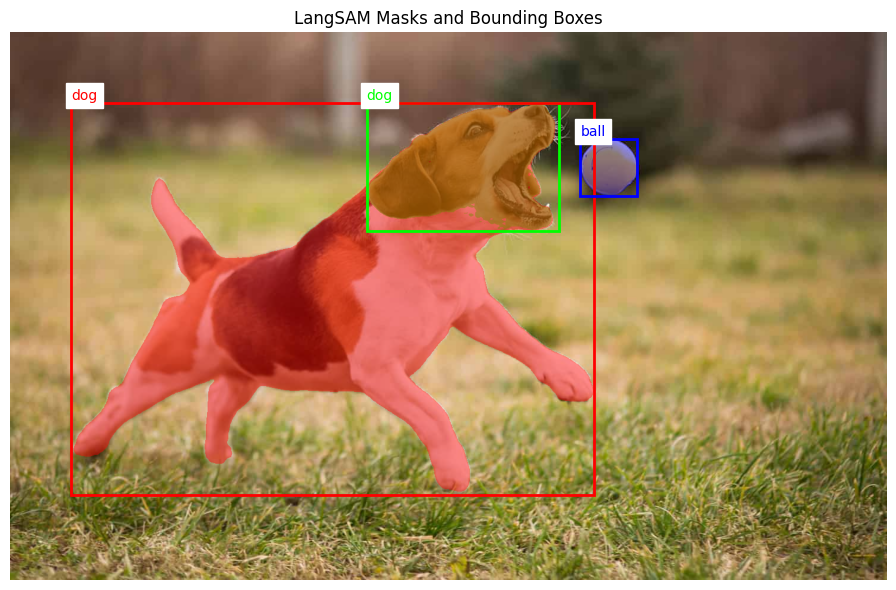

[ok] LangSAM inference test complete.


In [ ]:
# --- Preamble ---
from pathlib import Path
import os
import warnings
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from lang_sam import LangSAM

# --- Configuration & Setup ---
# Set CUDA architecture list if not set, crucial for JIT compilation
if "TORCH_CUDA_ARCH_LIST" not in os.environ and torch.cuda.is_available():
    major, minor = torch.cuda.get_device_capability()
    os.environ["TORCH_CUDA_ARCH_LIST"] = f"{major}.{minor}"

# Suppress a known, benign warning
warnings.filterwarnings(
    "ignore",
    message="The given NumPy array is not writable, and PyTorch does not support non-writable tensors."
)

# Define project paths
PROJECT_ROOT = Path("/home/nico/Projects/final_project/")
CKPT_PATH = PROJECT_ROOT / "models/sam/sam2.1_hiera_large.state_dict.pt"
IMG_PATH = PROJECT_ROOT / "test_assets/sample.jpg"

# --- Helper Function: Checkpoint Validation ---
def ensure_langsam_checkpoint(src: Path, dst: Path) -> Path:
    """
    Validates and reformats a SAM checkpoint if necessary for LangSAM.

    LangSAM expects the state_dict to be nested under a 'model' key. This
    function checks for common formats and creates a compatible, wrapped
    checkpoint if needed.

    Args:
        src: Path to the original downloaded checkpoint.
        dst: Path to write the reformatted checkpoint if necessary.

    Returns:
        The path to the compatible checkpoint to be used by the model.
    
    Raises:
        ValueError: If the checkpoint structure is unrecognized.
    """
    ckpt = torch.load(src, map_location="cpu")
    # Format is already correct
    if isinstance(ckpt, dict) and "model" in ckpt:
        return src
    # Common format with 'state_dict' key
    if isinstance(ckpt, dict) and "state_dict" in ckpt:
        dst.parent.mkdir(parents=True, exist_ok=True)
        torch.save({"model": ckpt["state_dict"]}, dst)
        return dst
    # Raw state_dict, needs wrapping
    if isinstance(ckpt, dict):
        dst.parent.mkdir(parents=True, exist_ok=True)
        torch.save({"model": ckpt}, dst)
        return dst
    raise ValueError("Unsupported checkpoint structure for SAM 2.1 Hiera Large.")

# --- Main Test Logic ---
print("[step] Verifying LangSAM assets and checkpoint...")
CKPT_USE = ensure_langsam_checkpoint(
    CKPT_PATH,
    PROJECT_ROOT / "models/sam/sam2.1_hiera_large.langsam.pt"
)

# Load and prepare the image
img_pil = Image.open(IMG_PATH).convert("RGB")
img_np = np.asarray(img_pil, dtype=np.float32).copy() / 255.0

print("[step] Initializing LangSAM model...")
model = LangSAM("sam2.1_hiera_large", str(CKPT_USE))

# Define prompts and visualization parameters
prompts = ["dog", "ball"]
alpha = 0.45
overlay = img_np.copy()
COLORS = {0: (0, 1, 0), 1: (1, 0, 0), 2: (0, 0, 1)} # Green, Red, Blue

# Run inference and generate overlays
print("[step] Running LangSAM inference...")
boxes_to_draw = []
mask_count = 0
for prompt in prompts:
    out = model.predict([img_pil], [prompt])[0]
    masks = out.get("masks")
    if masks is None or len(masks) == 0:
        print(f"[info] No mask returned for prompt: {prompt}")
        continue
    
    for i, mask in enumerate(masks):
        color = COLORS.get(mask_count % len(COLORS))
        mask_count += 1
        mask_bool = (mask > 0.5) if mask.max() <= 1.0 else mask.astype(bool)
        
        color_mask = np.zeros_like(overlay)
        for c in range(3):
            color_mask[..., c] = color[c]
        
        overlay[mask_bool] = (1 - alpha) * overlay[mask_bool] + alpha * color_mask[mask_bool]
        
        if i < len(out.get("boxes", [])):
            boxes_to_draw.append((out["boxes"][i], out["labels"][i], color))

# --- Plotting ---
print("[step] Visualizing results...")
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(overlay)
for box, label, color in boxes_to_draw:
    x1, y1, x2, y2 = map(int, box)
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, max(y1 - 5, 10), str(label), fontsize=10, color=color, backgroundcolor='white')

ax.set_title("LangSAM Masks and Bounding Boxes")
ax.axis("off")
plt.tight_layout()
plt.show()
print("[ok] LangSAM inference test complete.")

---

### **Phase 4: Freeze Environment Dependencies**

**Objective:** To generate definitive lists of all installed packages in the environment for archival and future replication.

**Rationale:** Freezing dependencies captures the exact state of the environment, ensuring that the analysis can be reproduced precisely at a later date or on a different machine.

**Methodology:** The `pip freeze` and `conda list --explicit` commands are used to generate two artifact files. These files provide a complete record of both Python-level and Conda-level dependencies, including compiled libraries.

**Outputs:**
*   `outputs/artifacts/pip_freeze.txt`
*   `outputs/artifacts/conda_list_explicit.txt`

In [11]:
# --- Preamble ---
import subprocess
from pathlib import Path

# --- Configuration ---
PROJECT_ROOT = Path("/home/nico/Projects/final_project/") # Assumes notebook is run from project root/notebooks
ARTIFACTS_DIR = PROJECT_ROOT / "outputs" / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

pip_file = ARTIFACTS_DIR / "pip_freeze.txt"
conda_file = ARTIFACTS_DIR / "conda_list_explicit.txt"

# --- Export Pip Packages ---
print("[step] Exporting pip-installed packages...")
subprocess.run(["pip", "freeze"], stdout=open(pip_file, "w"), check=True)
print(f"[saved] Pip package list saved to: {pip_file}")

# --- Export Conda Environment ---
print("[step] Exporting explicit conda environment spec...")
subprocess.run(["conda", "list", "--explicit"], stdout=open(conda_file, "w"), check=True)
print(f"[saved] Conda package list saved to: {conda_file}")

# --- Preview Generated Files ---
print("\n[preview] First 10 lines of pip_freeze.txt:")
with open(pip_file) as f:
    for i, line in enumerate(f):
        if i >= 10: break
        print(line.rstrip())

print("\n[preview] First 10 lines of conda_list_explicit.txt:")
with open(conda_file) as f:
    for i, line in enumerate(f):
        if i >= 10: break
        print(line.rstrip())

print("\n[ok] Environment freezing complete.")

[step] Exporting pip-installed packages...
[saved] Pip package list saved to: /home/nico/Projects/final_project/outputs/artifacts/pip_freeze.txt
[step] Exporting explicit conda environment spec...
[saved] Conda package list saved to: /home/nico/Projects/final_project/outputs/artifacts/conda_list_explicit.txt

[preview] First 10 lines of pip_freeze.txt:
anaconda-anon-usage @ file:///croot/anaconda-anon-usage_1710965072196/work
annotated-types==0.7.0
appnope==0.1.4
archspec @ file:///croot/archspec_1709217642129/work
asttokens==3.0.0
boltons @ file:///work/perseverance-python-buildout/croot/boltons_1698851177130/work
Brotli @ file:///croot/brotli-split_1714483155106/work
cachetools==5.5.2
certifi @ file:///croot/certifi_1725551672989/work/certifi
cffi @ file:///croot/cffi_1726856441404/work

[preview] First 10 lines of conda_list_explicit.txt:
# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
# created-by: conda 